## Code Modules & Helpful Functions

In [1]:
!pip install tensorflow_datasets

     |████████████████████████████████| 3.3 MB 4.7 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,pylab as pl
import os,h5py,cv2,tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as th
from sklearn.model_selection import train_test_split
fpath='../input/flower-color-images/'
fw='weights.best.hdf5'

In [3]:
def prepro_resize_display(x_train,y_train,x_test,y_test,
                          n_classes,pixels):
    x_train=np.array(tf.image.resize(x_train,[pixels,pixels]))
    x_test=np.array(tf.image.resize(x_test,[pixels,pixels]))
    cy_train=np.array(tf.keras.utils\
    .to_categorical(y_train,n_classes),dtype='int32')
    cy_test=np.array(tf.keras.utils\
     .to_categorical(y_test,n_classes),dtype='int32')
    n=int(len(x_test)/2)
    x_valid,y_valid,cy_valid=x_test[:n],y_test[:n],cy_test[:n]
    x_test,y_test,cy_test=x_test[n:],y_test[n:],cy_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype],
                     [cy_train.shape,cy_valid.shape,cy_test.shape],
                     [cy_train.dtype,cy_valid.dtype,cy_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type',
                           'shape of encoded label','type of encoded label'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]

## Data
### From external sources

In [4]:
(ds_train1,ds_test1),ds_info1=\
tfds.load('stanford_dogs',split=['train','test'],
          shuffle_files=True,as_supervised=True,
          with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete3JP24X/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete3JP24X/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


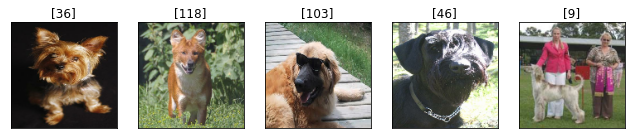

In [5]:
s=128; ntrain=12000; i=0
x_train1=np.zeros((ntrain,s,s,3),dtype='float32')
y_train1=np.zeros((ntrain,1),dtype='int32')
for f,t in ds_train1.take(ntrain):
    f=tf.image.resize(f,[s,s])
    x_train1[i,:]=f/255
    y_train1[i,:]=t; i+=1
fig=pl.figure(figsize=(11,4))    
for i in range(5):
    ax=fig.add_subplot(1,5,i+1,\
    xticks=[],yticks=[],title=y_train1[i])
    ax.imshow((x_train1[i]))

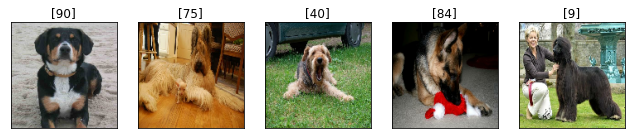

In [6]:
ntest=8580; i=0
x_test1=np.zeros((ntest,s,s,3),dtype='float32')
y_test1=np.zeros((ntest,1),dtype='int32')
for f,t in ds_test1.take(ntest):
    f=tf.image.resize(f,[s,s])
    x_test1[i,:]=f/255
    y_test1[i,:]=t; i+=1
fig=pl.figure(figsize=(11,4))    
for i in range(5):
    ax=fig.add_subplot(1,5,i+1,\
    xticks=[],yticks=[],title=y_test1[i])
    ax.imshow((x_test1[i]))

In [7]:
with h5py.File('DogBreedImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train1)
    f.create_dataset('train_labels',data=y_train1)
    f.create_dataset('test_images',data=x_test1)
    f.create_dataset('test_labels',data=y_test1)
os.stat('DogBreedImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=4046279056, st_atime=1590591756, st_mtime=1590591762, st_ctime=1590591762)

In [8]:
[[x_train1,x_valid1,x_test1],
 [y_train1,y_valid1,y_test1],
 [cy_train1,cy_valid1,cy_test1]]=\
prepro_resize_display(x_train1,y_train1,x_test1,y_test1,120,96)

,train,valid,test
image shape,"(12000, 96, 96, 3)","(4290, 96, 96, 3)","(4290, 96, 96, 3)"
image type,float32,float32,float32
label shape,"(12000, 1)","(4290, 1)","(4290, 1)"
label type,int32,int32,int32
shape of encoded label,"(12000, 120)","(4290, 120)","(4290, 120)"
type of encoded label,int32,int32,int32


### From internal sources

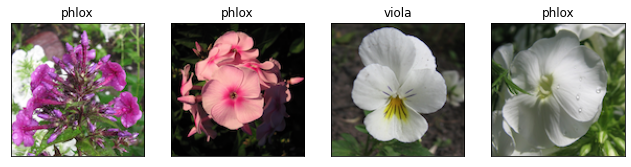

In [9]:
f=h5py.File(fpath+'FlowerColorImages.h5','r')
keys=list(f.keys())
images=np.array(f[keys[0]],dtype='float32')/255
labels=np.array(f[keys[1]],dtype='int32').reshape(-1,1)
x_train2,x_test2,y_train2,y_test2=\
train_test_split(images,labels,test_size=.1,random_state=1)
names=['phlox','rose','calendula','iris',
       'max chrysanthemum','bellflower','viola',
       'rudbeckia laciniata','peony','aquilegia']
fig=pl.figure(figsize=(11,4))
n=np.random.randint(1,30)
for i in range(n,n+4):
    ax=fig.add_subplot(1,4,i-n+1,xticks=[],yticks=[],\
    title=names[int(labels[i])])
    ax.imshow((images[i]))

In [10]:
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2],
 [cy_train2,cy_valid2,cy_test2]]=\
prepro_resize_display(x_train2,y_train2,x_test2,y_test2,10,96)

,train,valid,test
image shape,"(189, 96, 96, 3)","(10, 96, 96, 3)","(11, 96, 96, 3)"
image type,float32,float32,float32
label shape,"(189, 1)","(10, 1)","(11, 1)"
label type,int32,int32,int32
shape of encoded label,"(189, 10)","(10, 10)","(11, 10)"
type of encoded label,int32,int32,int32


## NN Examples for Classification

In [11]:
def premodel(pix,den,mh,lbl):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='categorical_crossentropy')
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [12]:
[handle_base,pixels]=["mobilenet_v2_075_96",96]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)
fw='weights.best.hdf5'

In [13]:
model=premodel(pixels,1024,mhandle,120)
history=model.fit(x=x_train1,y=cy_train1,batch_size=64,
                  epochs=25,callbacks=cb(fw),
                  validation_data=(x_valid1,cy_valid1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              1382064   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               123000    
Total params: 2,816,808
Trainable params: 2,790,168
Non-trainable params: 26,640
_________________________________________________________________


None

Train on 12000 samples, validate on 4290 samples
Epoch 1/25
11968/12000 [============================>.] - ETA: 0s - loss: 3.5016 - accuracy: 0.2001
Epoch 00001: val_loss improved from inf to 3.77137, saving model to weights.best.hdf5
12000/12000 [==============================] - 223s 19ms/sample - loss: 3.4992 - accuracy: 0.2006 - val_loss: 3.7714 - val_accuracy: 0.2068
Epoch 2/25
11968/12000 [============================>.] - ETA: 0s - loss: 2.5109 - accuracy: 0.3653
Epoch 00002: val_loss improved from 3.77137 to 2.82836, saving model to weights.best.hdf5
12000/12000 [==============================] - 208s 17ms/sample - loss: 2.5106 - accuracy: 0.3653 - val_loss: 2.8284 - val_accuracy: 0.3030
Epoch 3/25
11968/12000 [============================>.] - ETA: 0s - loss: 2.0609 - accuracy: 0.4567
Epoch 00003: val_loss improved from 2.82836 to 2.62897, saving model to weights.best.hdf5
12000/12000 [==============================] - 204s 17ms/sample - loss: 2.0599 - accuracy: 0.4568 - val_l

In [14]:
model.load_weights(fw)
model.evaluate(x_test1,cy_test1)

4290/4290 [==============================] - 12s 3ms/sample - loss: 2.6253 - accuracy: 0.3611


[2.62534302670361, 0.36107227]

In [15]:
model=premodel(pixels,512,mhandle,10)
history=model.fit(x=x_train2,y=cy_train2,batch_size=64,
                  epochs=10,callbacks=cb(fw),
                  validation_data=(x_valid2,cy_valid2))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              1382064   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 2,043,066
Trainable params: 2,016,426
Non-trainable params: 26,640
_________________________________________________________________


None

Train on 189 samples, validate on 10 samples
Epoch 1/10
128/189 [===================>..........] - ETA: 3s - loss: 2.4896 - accuracy: 0.2031 
Epoch 00001: val_loss improved from inf to 1.67294, saving model to weights.best.hdf5
189/189 [==============================] - 10s 53ms/sample - loss: 2.2358 - accuracy: 0.2751 - val_loss: 1.6729 - val_accuracy: 0.6000
Epoch 2/10
128/189 [===================>..........] - ETA: 0s - loss: 0.4569 - accuracy: 0.9062
Epoch 00002: val_loss did not improve from 1.67294
189/189 [==============================] - 3s 16ms/sample - loss: 0.4340 - accuracy: 0.9153 - val_loss: 2.2640 - val_accuracy: 0.5000
Epoch 3/10
128/189 [===================>..........] - ETA: 0s - loss: 0.1476 - accuracy: 0.9844
Epoch 00003: val_loss did not improve from 1.67294
189/189 [==============================] - 3s 16ms/sample - loss: 0.1297 - accuracy: 0.9894 - val_loss: 2.6898 - val_accuracy: 0.5000
Epoch 4/10
128/189 [===================>..........] - ETA: 0s - loss: 0.167

In [16]:
model.load_weights(fw)
model.evaluate(x_test2,cy_test2)

11/11 [==============================] - 0s 3ms/sample - loss: 1.5163 - accuracy: 0.3636


[1.5163347721099854, 0.36363637]